In [37]:
import matplotlib as plt
import pandas as pd
import numpy as np
import itertools
import requests
import bs4
import os


# folder
folder = 'datasets/'

lis_datasets = os.listdir(folder)
lis_paths = [folder + dataset for dataset in lis_datasets]
lis_paths

['datasets/committs.csv',
 'datasets/licenses.csv',
 'datasets/sample_commits.csv',
 'datasets/sample_repos_1.csv',
 'datasets/sample_repos_2.csv']

In [38]:
# Define the web-scrapping function to get the languages from a git repository
def _scrap_technologies_from_GitHub(languages: list, source):
    """Web Scrapping to Fetch Languages used in a GitHub repository and save them in the languages input list.

    Args:
        languages: A list with empty or existing Languages values.
        source: raw response content from HTTP Request.

    Returns:
        None
    """

    soup = bs4.BeautifulSoup(source.text, "html.parser")
    divs = soup.find_all("div", class_="BorderGrid-row")
    for div in divs:

        section = div.div
        if section.h2 is not None:
            if section.h2.text == "Languages":
                # print(section.h2.text)
                for span in section.div.span:

                    if type(span) is bs4.element.Tag:
                        languageAndPercent = span.get("aria-label")
                        # print(languageAndPercent.split()[0])
                        languages.append(languageAndPercent.split()[0])
                # print()
    return None

In [39]:
# Read the datasets
committs            = pd.read_csv(lis_paths[0])
licenses            = pd.read_csv(lis_paths[1])
sample_commits = pd.read_csv(lis_paths[2])
sample_repos_1 = pd.read_csv(lis_paths[3])
sample_repos_2 = pd.read_csv(lis_paths[4])

In [40]:
# Append sample_repos and delete duplicates
sample_repos = pd.concat([sample_repos_1, sample_repos_2], ignore_index=True).drop_duplicates(subset=['repo_name'])

# Split repo_name and author
sample_repos['author'] = [item[0] for item in sample_repos['repo_name'].str.split('/')]
sample_repos['repo'] = [item[1] for item in sample_repos['repo_name'].str.split('/')]
sample_repos

,repo_name,watch_count,author,repo
0,0----0/Terra-3d-Experiments,3,0----0,Terra-3d-Experiments
1,0-1-0/lightblue-0.4,6,0-1-0,lightblue-0.4
2,0-14N/NDroid,4,0-14N,NDroid
3,0-Eclipse-0/Eclipse,3,0-Eclipse-0,Eclipse
4,0-Eclipse-0/Messenger,4,0-Eclipse-0,Messenger
...,...,...,...,...
399995,openstack/vmtp,7,openstack,vmtp
399996,openstack/vitrage-specs,7,openstack,vitrage-specs
399997,openstack/vitrage-dashboard,9,openstack,vitrage-dashboard
399998,openstack/vitrage,15,openstack,vitrage


In [41]:
# Add github url column
sample_repos['url'] = 'https://github.com/' + sample_repos['repo_name']

# Add license column
sample_repos = pd.merge(sample_repos, licenses, how='inner', on='repo_name')

# Re-order
sample_repos = sample_repos[['url', 'repo', 'author', 'license', 'watch_count']]

In [42]:
# Add languages column from web_scrapping function
global_lis = []

for i, url in enumerate(sample_repos['url']):
    lis = []
    
    if i < 1000:
        try:
            source = requests.get(url.strip())
            if not source.ok:
                # print(source.reason)
                # print("There could be an error in the URL\n")
                lis = [None]
            else:
                _scrap_technologies_from_GitHub(lis, source)
        except Exception as e:
            lis = [None]
    else:
        lis=[None]
    global_lis.append(lis)
    # print(global_lis)

In [43]:
# Add global_lis of languages to a new column in asmple_repos
sample_repos['languages'] = global_lis
sample_repos

,url,repo,author,license,watch_count,languages
0,https://github.com/01miru/HomeSense,HomeSense,01miru,mit,3,"[Swift, Other]"
1,https://github.com/01org/yask,yask,01org,mit,6,"[C++, Perl, Makefile, Python, Other]"
2,https://github.com/06wj/FL,FL,06wj,mit,3,"[JavaScript, Python]"
3,https://github.com/0legAdamov/AOIntroViewContr...,AOIntroViewController,0legAdamov,mit,3,[None]
4,https://github.com/0of/Promise2,Promise2,0of,mit,4,"[C++, CMake, Other]"
...,...,...,...,...,...,...
15346,https://github.com/opentok/opentok-ios-sdk-sam...,opentok-ios-sdk-samples,opentok,mit,32,[None]
15347,https://github.com/opentok/opentok-hardware-se...,opentok-hardware-setup.js,opentok,mit,3,[None]
15348,https://github.com/opentable/explicitobjectmap...,explicitobjectmap-node,opentable,mit,5,[None]
15349,https://github.com/openstreetmap/iD,iD,openstreetmap,isc,118,[None]


In [44]:
# Get rid of rows without a language
for i, item in enumerate(sample_repos['languages']):
    if None in item:
        sample_repos.drop(i, inplace=True)
sample_repos

,url,repo,author,license,watch_count,languages
0,https://github.com/01miru/HomeSense,HomeSense,01miru,mit,3,"[Swift, Other]"
1,https://github.com/01org/yask,yask,01org,mit,6,"[C++, Perl, Makefile, Python, Other]"
2,https://github.com/06wj/FL,FL,06wj,mit,3,"[JavaScript, Python]"
4,https://github.com/0of/Promise2,Promise2,0of,mit,4,"[C++, CMake, Other]"
5,https://github.com/0racle/p6-wig,p6-wig,0racle,artistic-2.0,3,[Other]
...,...,...,...,...,...,...
995,https://github.com/HelloYu/Restaurant-Manageme...,Restaurant-Management-System,HelloYu,mit,3,"[JavaScript, HTML]"
996,https://github.com/HenningM/jstimezonedetect,jstimezonedetect,HenningM,mit,2,"[JavaScript, Shell, HTML]"
997,https://github.com/HenrikJoreteg/clientconfig,clientconfig,HenrikJoreteg,mit,4,[JavaScript]
998,https://github.com/Hermanya/partial-applicatio...,partial-application-with-named-parameters,Hermanya,mit,4,[JavaScript]


In [45]:
# Save in the dataset
sample_repos.to_csv('github_repos_dataset.csv')

In [54]:
# Let's load in the final_dataset again
import pandas as pd
dataset = pd.read_csv('github_repos_dataset.csv').sort_values(by=['watch_count'], axis=0, ascending=False)
dataset

,Unnamed: 0,url,repo,author,license,watch_count,languages
67,72,https://github.com/AFNetworking/AFNetworking,AFNetworking,AFNetworking,mit,4115,"['Objective-C', 'Swift', 'Other']"
133,140,https://github.com/Alamofire/Alamofire,Alamofire,Alamofire,mit,3903,['Swift']
13,14,https://github.com/10up/flexibility,flexibility,10up,mit,1450,"['JavaScript', 'HTML', 'CSS']"
43,45,https://github.com/500px/greedo-layout-for-and...,greedo-layout-for-android,500px,mit,1131,['Java']
880,909,https://github.com/Gazler/githug,githug,Gazler,mit,1088,"['Shell', 'Ruby', 'Other']"
...,...,...,...,...,...,...,...
400,413,https://github.com/CacheControl/promise-series,promise-series,CacheControl,mit,2,['JavaScript']
399,412,https://github.com/CWDG/cwdg.github.io,cwdg.github.io,CWDG,mit,2,"['CSS', 'HTML', 'Ruby']"
398,411,https://github.com/CWBudde/Pascal-HTML5-Canvas,Pascal-HTML5-Canvas,CWBudde,mit,2,['Pascal']
391,403,https://github.com/CP-LUG/cplug.net,cplug.net,CP-LUG,mit,2,"['PHP', 'CSS', 'Hack']"


<Axes: xlabel='repo'>

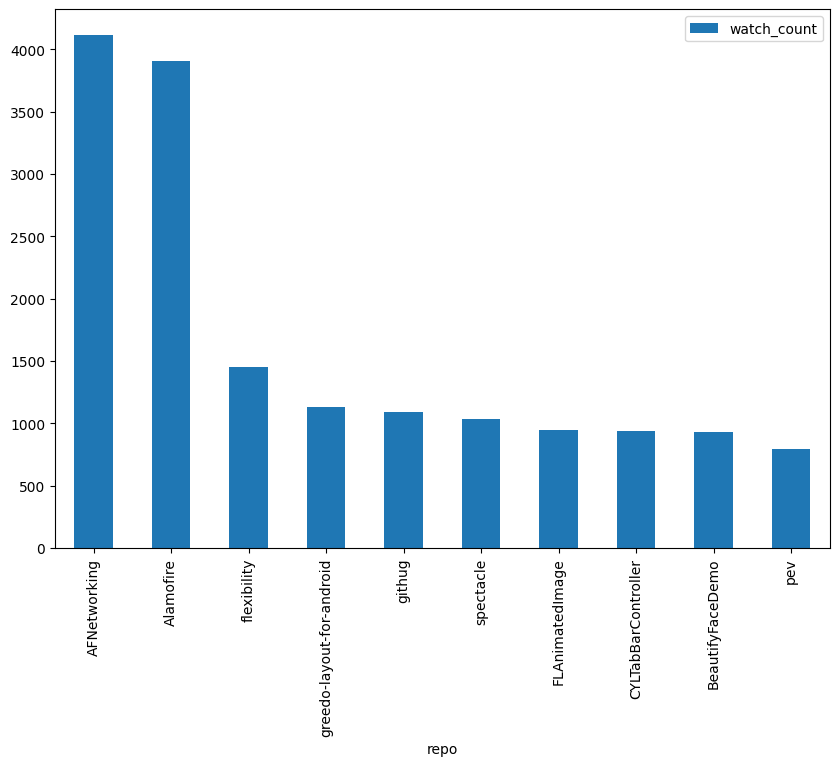

In [56]:
# Plot Top 10 watchers per Repo
dataset.set_index('repo')[['watch_count']][:10].plot(kind='bar', figsize=(10, 7))

<Axes: xlabel='author'>

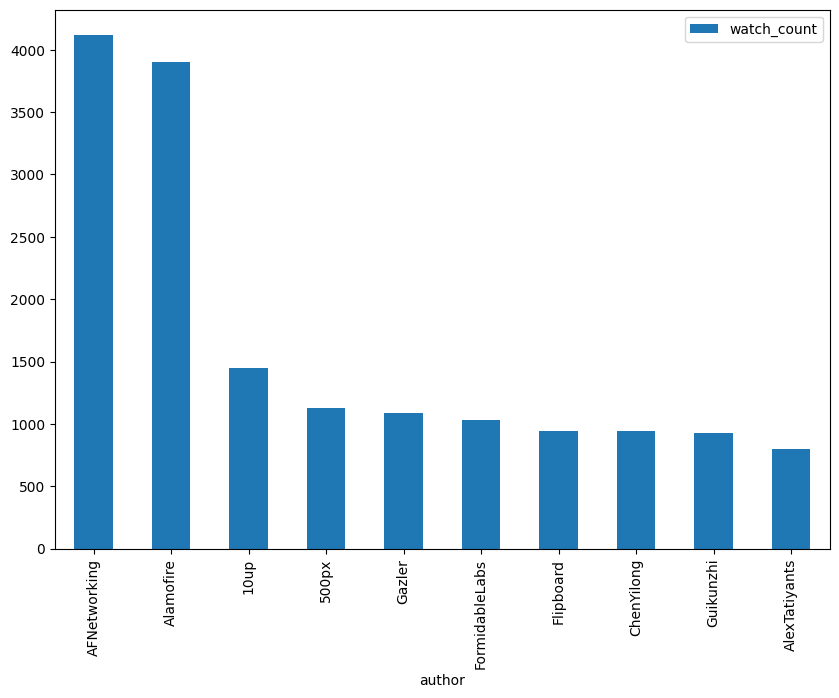

In [58]:
# Plot Top 10 watchers per author
dataset.set_index('author')[['watch_count']][:10].plot(kind='bar', figsize=(10, 7))

<Axes: xlabel='languages'>

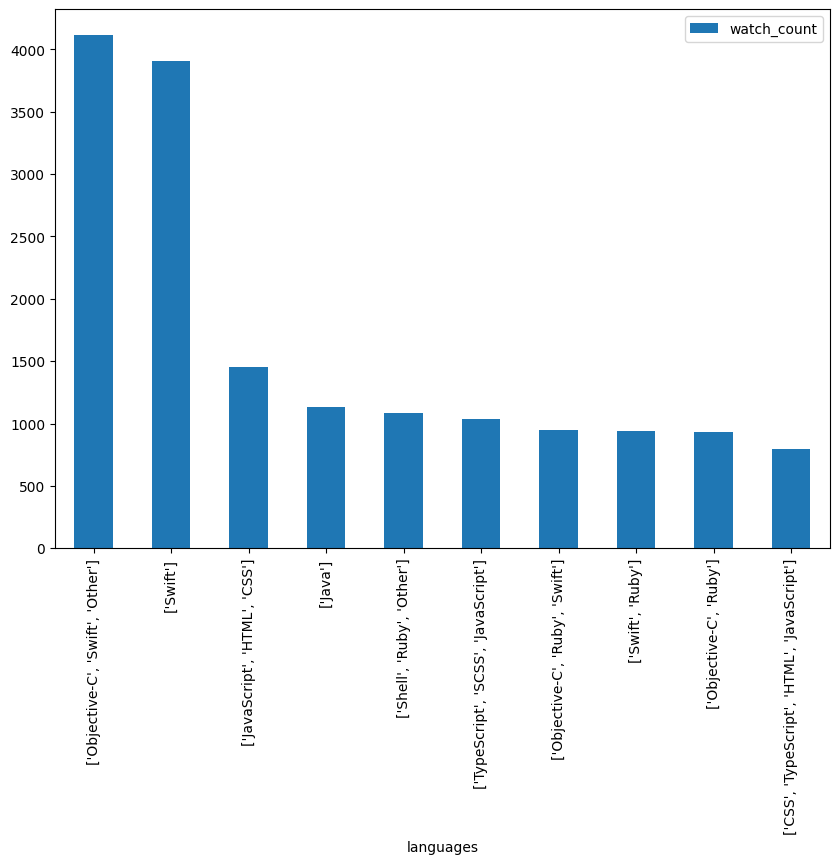

In [59]:
# Plot Top 10 watchers per language
dataset.set_index('languages')[['watch_count']][:10].plot(kind='bar', figsize=(10, 7))